# 📓 Modelo de OneClassSVM entrenado con 2F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## ✨ Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## 📌 Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## 🗂️ Entrada de datos:

- `../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt`

## 💾 Salida esperada:

- Mejor combinación de hiperparámetros
- Métricas de evaluación (f1-score, confusion matrix)
- Exportación de los UNIDs más anómalos


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score


In [2]:
# Load dataset
data_path = "../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
print(df_astro.columns)

df_astro.head()

Index(['E_peak', 'beta', 'sigma', 'beta_Rel', 'class'], dtype='object')


,E_peak,beta,sigma,beta_Rel,class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


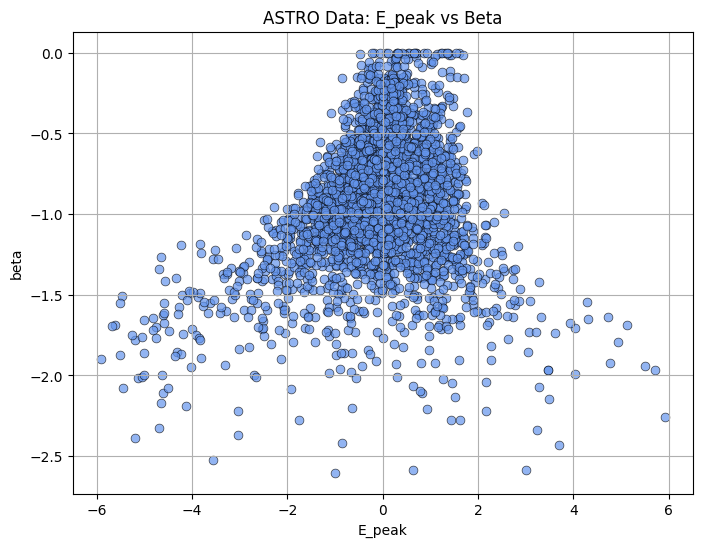

In [3]:
# Comprobamos la distribución de los datos astro antes de escalar
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_astro,
    x="E_peak",
    y="beta",
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

In [4]:
X = df_astro[["beta", "E_peak"]].values
y = df_astro["class"].values

# SPLIT: Train / Val / Test
# Dividimos todo astro en train y temp
# y después dividimos temp en val y test

# 60% train, 20% val, 20% test

# de esta manera, el test set no se ve en el entrenamiento
# y el val set se usa para ajustar los hiperparámetros
# X_train, X_temp = train_test_split(X, test_size=0.4, random_state=42)
# X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)
# SPLIT: Train / Val / Test (with both X and y!)

# otro enfoque - SPLIT: Train / Val / Test (X y también y para que vayan juntos)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


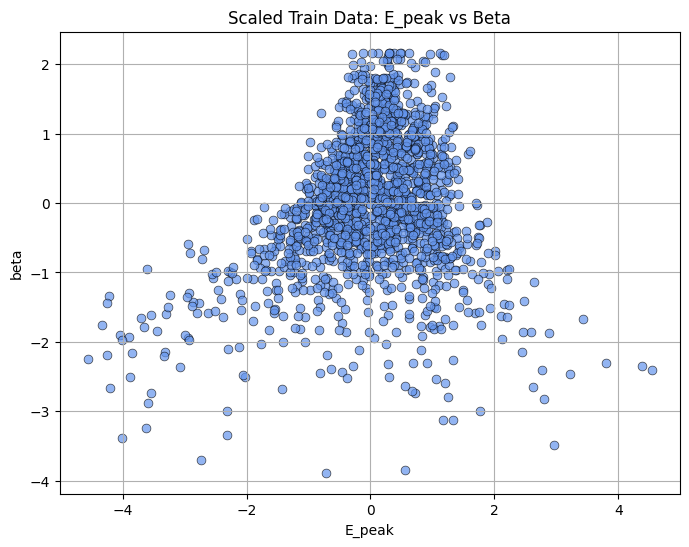

In [5]:
# Comprobamos que los datos están bien escalados
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x=X_train_scaled[:, 1],
    y=X_train_scaled[:, 0],
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled Train Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()


In [6]:
# Define hyperparameter ranges:

nu_values = [0.005, 0.01, 0.02, 0.05]
# nu should be a float in the interval (0, 1], by default 0.5
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5)) 
# gamma can be {‘scale’, ‘auto’} or float, default=’scale’
# if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
# if ‘auto’, uses 1 / n_features
# if float, must be non-negative.

# Track results
results = []
best_score = np.inf
best_model = None
best_params = {}

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)
        
        # Predict on validation set
        preds = model.predict(X_val_scaled)

        n_outliers = np.sum(preds == -1)  # -1 means "anomaly"
        
        results.append({'nu': nu, 'gamma': gamma, 'outliers': n_outliers})
        
        if n_outliers < best_score:
            best_score = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Show best hyperparameters
print(f"✅ Best Parameters: nu = {best_params['nu']}, gamma = {best_params['gamma']}")
print(f"🚨 Outliers on Validation Set: {best_score}")


✅ Best Parameters: nu = 0.005, gamma = 0.1
🚨 Outliers on Validation Set: 4


In [7]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score
import numpy as np

# Hyperparameter ranges
nu_values = [0.005, 0.01, 0.02, 0.05]
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))

results = []
best_score = 0  # Higher F1 is better
best_model = None
best_params = {}

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)

        preds = model.predict(X_val_scaled)  # 1 = inlier, -1 = outlier
        pred_labels = np.where(preds == 1, 0, 1)  # Map to 0 = normal, 1 = anomaly
        true_labels = y_val  # all are 0.0 (normal)

        f1 = f1_score(true_labels, pred_labels, pos_label=0)

        results.append({'nu': nu, 'gamma': gamma, 'f1_score': f1})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

print(f"✅ Best Parameters: nu = {best_params['nu']}, gamma = {best_params['gamma']}")
print(f"📈 Best F1 Score on Validation Set: {best_score:.4f}")


✅ Best Parameters: nu = 0.005, gamma = 0.1
📈 Best F1 Score on Validation Set: 0.9965


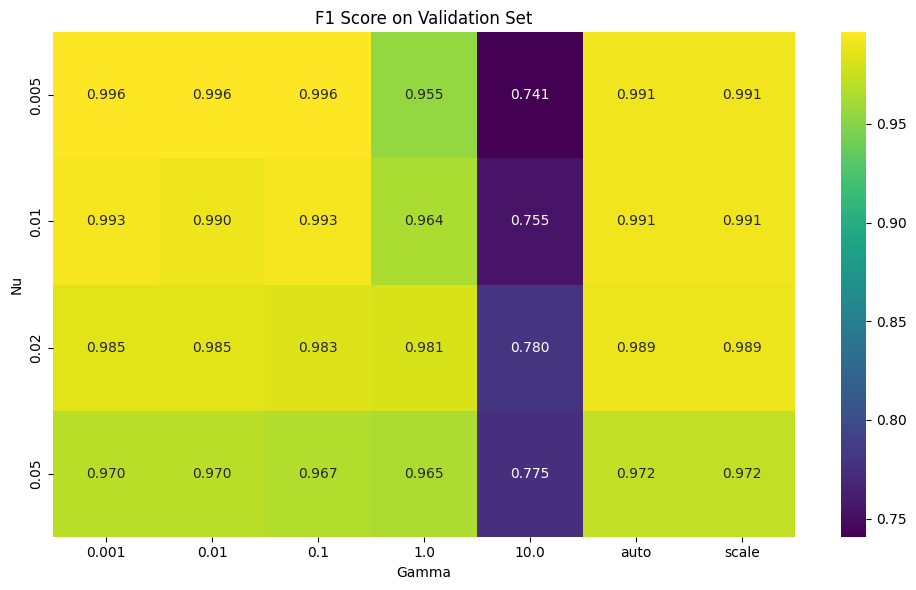

In [8]:
df_results = pd.DataFrame(results)
df_results['gamma_str'] = df_results['gamma'].astype(str)

heatmap_data = df_results.pivot(index='nu', columns='gamma_str', values='f1_score')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='viridis')
plt.title("F1 Score on Validation Set")
plt.xlabel("Gamma")
plt.ylabel("Nu")
plt.tight_layout()
plt.show()

In [9]:
# Evaluate on the test set
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)

print(f"🔍 Outliers on Final Test Set: {n_test_outliers}")

🔍 Outliers on Final Test Set: 6


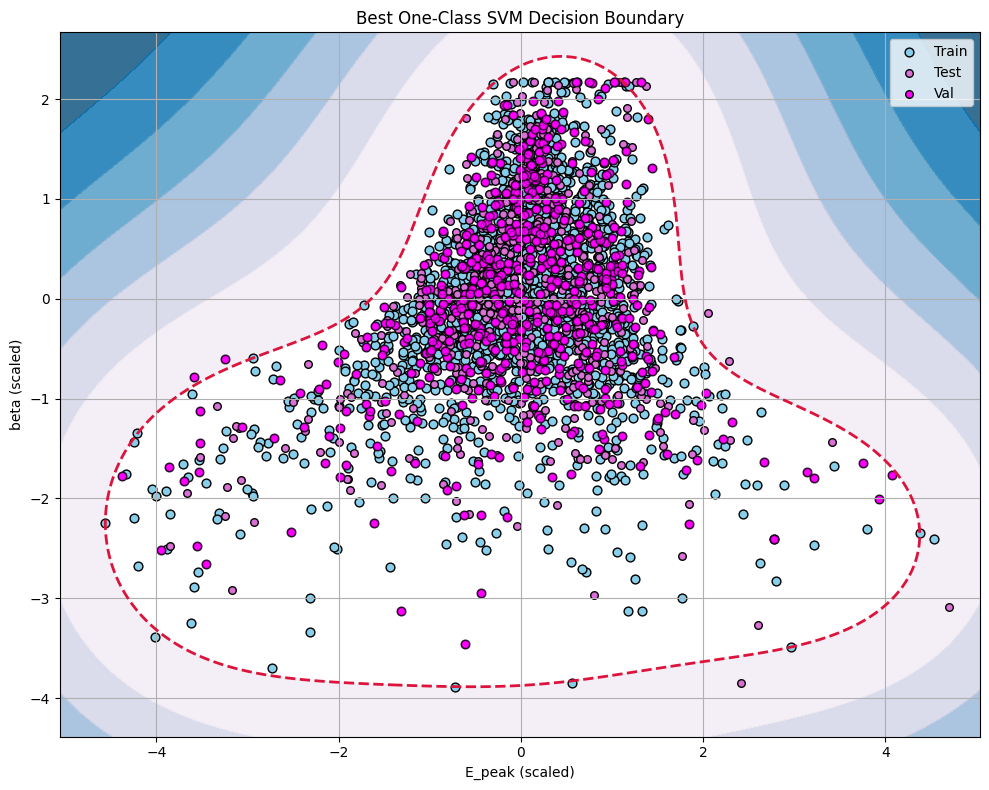

In [10]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

# xx = E_peak
# yy = beta
# grid = np.c_[beta, E_peak]  # i.e., np.c_[yy, xx]

grid = np.c_[yy.ravel(), xx.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='Train')
plt.scatter(X_test_scaled[:, 1], X_test_scaled[:, 0], c='orchid', edgecolors='k', s=30, label='Test')
plt.scatter(X_val_scaled[:, 1], X_val_scaled[:, 0], c='magenta', edgecolors='k', s=30, label='Val')
plt.scatter(X_val_scaled[:, 1], X_val_scaled[:, 0], c='magenta', edgecolors='k', s=40, alpha=0.7)


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Generate random 'noise' in data for testing Precision and Recall

In [11]:
rng = np.random.RandomState(42)
n_anomalies = 20

# Assuming 2 features (beta and E_peak), generate noise in [-5, 5] range
# # Generate 20 fake anomalies from uniform noise
anomalies = rng.uniform(low=-5, high=5, size=(n_anomalies, 2))

# Scale anomalies to match the model's feature space
anomalies_scaled = scaler.transform(anomalies)

# Combine them with real "normal" validation data
X_eval = np.vstack([X_val_scaled, anomalies_scaled])
y_eval = np.hstack([np.ones(len(X_val_scaled)), -1 * np.ones(len(anomalies_scaled))])
# 🚦 Label meaning:
# 1 = normal (inlier)
# -1 = anomaly (outlier)

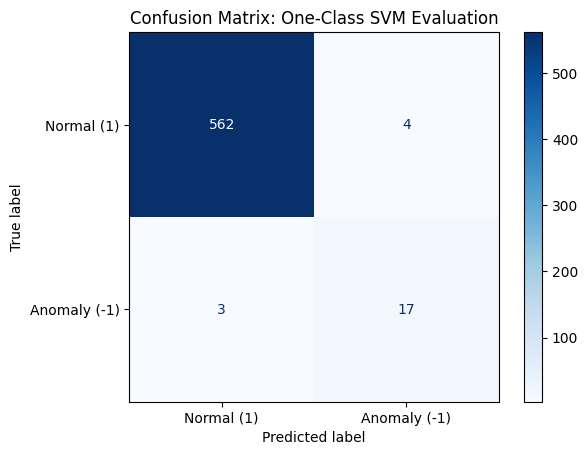

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the best model
y_pred = best_model.predict(X_eval)  # Outputs 1 (inlier), -1 (outlier)

# Compute confusion matrix
cm = confusion_matrix(y_eval, y_pred, labels=[1, -1])

# Display matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (1)", "Anomaly (-1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: One-Class SVM Evaluation")
plt.grid(False)
plt.show()

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_eval, y_pred, labels=[1, -1], target_names=["Normal", "Anomaly"]))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       566
     Anomaly       0.81      0.85      0.83        20

    accuracy                           0.99       586
   macro avg       0.90      0.92      0.91       586
weighted avg       0.99      0.99      0.99       586



# Predict on UNIDs

In [14]:
unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


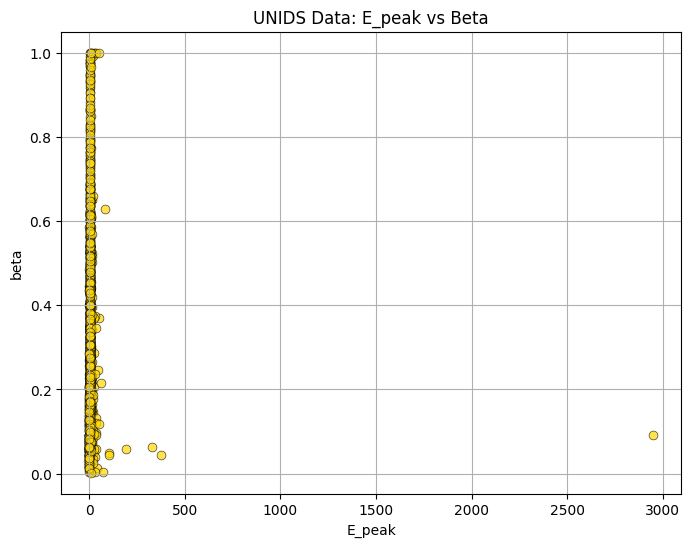

In [15]:
# Scatter de unids para comprobar que no hay problemas
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_unids,
    x="E_peak",
    y="beta",
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("UNIDS Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

In [16]:
# convertimos a logaritmo
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

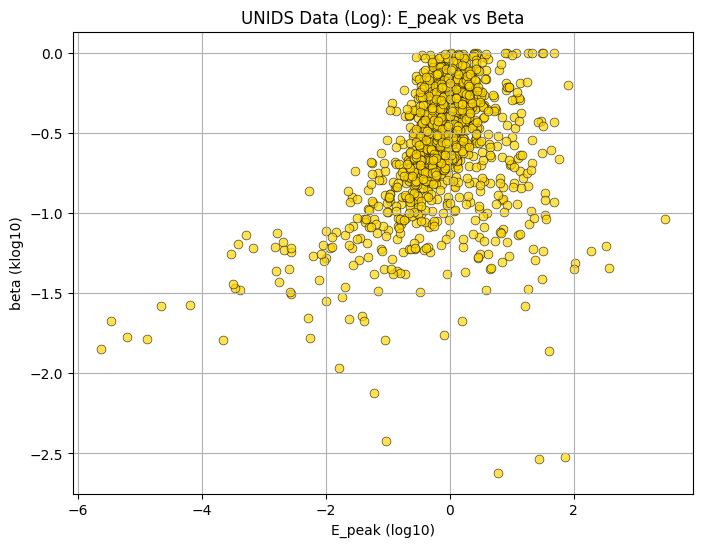

In [17]:
# scatter de unids después de log
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_unids_log,
    x="E_peak",
    y="beta",
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("UNIDS Data (Log): E_peak vs Beta")
plt.xlabel("E_peak (log10)")
plt.ylabel("beta (klog10)")
plt.grid(True)
plt.show()

In [18]:
# Extraer y escalar
X_unids_log = df_unids_log[["beta", "E_peak"]].values
X_unids_scaled = scaler.transform(X_unids_log)

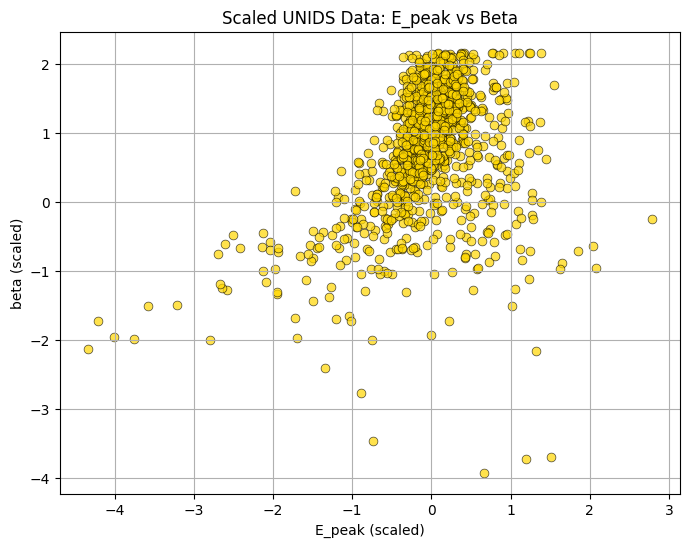

In [19]:
# Scatter de unids después de escalar
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_unids_scaled[:, 1],
    y=X_unids_scaled[:, 0],
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled UNIDS Data: E_peak vs Beta")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.grid(True)
plt.show()

In [20]:
# Predecir sobre unids usando el mejor modelo
# preds_non_astro = best_model.predict(X_unids_scaled)
unids_preds = best_model.predict(X_unids_scaled)

n_outliers = np.sum(unids_preds == -1)
n_normals = np.sum(unids_preds == 1)

print(f"🚀 Predicted ASTRO-like: {n_normals}")
print(f"❗ Predicted not ASTRO-like (anomalies): {n_outliers}")


🚀 Predicted ASTRO-like: 1117
❗ Predicted not ASTRO-like (anomalies): 8


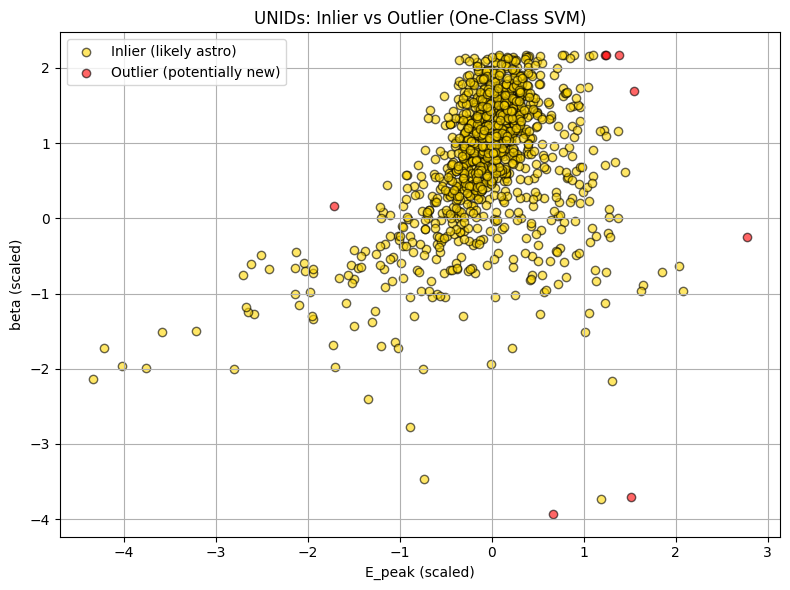

In [21]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(8, 6))
plt.scatter(inliers[:, 1], inliers[:, 0], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 1], outliers[:, 0], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

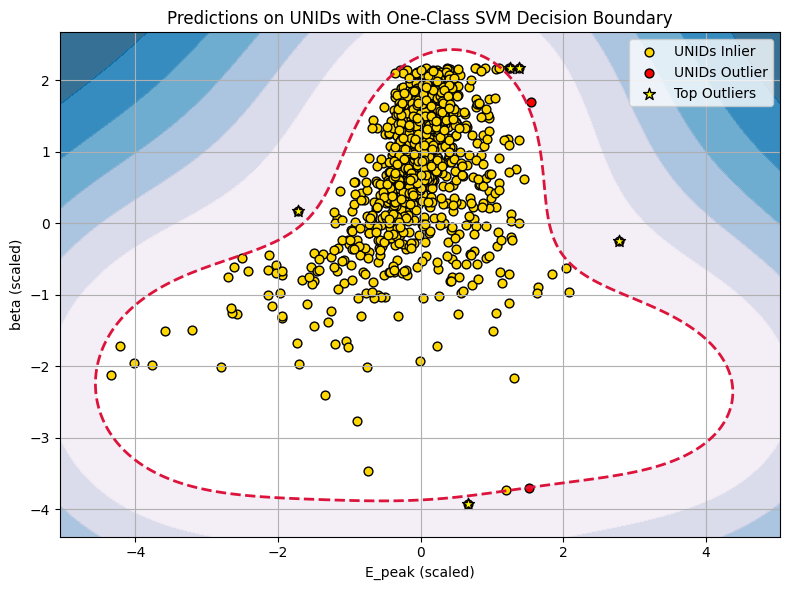

In [22]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

grid = np.c_[yy.ravel(), xx.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

preds_unids = best_model.predict(X_unids_scaled)
inliers = X_unids_scaled[preds_unids == 1]
outliers = X_unids_scaled[preds_unids == -1]

plt.scatter(inliers[:, 1], inliers[:, 0], c='gold', edgecolors='k', s=40, label='UNIDs Inlier')
plt.scatter(outliers[:, 1], outliers[:, 0], c='red', edgecolors='k', s=40, label='UNIDs Outlier')

# Highlight most anomalous UNIDs using their lowest decision score:
decision_scores = best_model.decision_function(X_unids_scaled)
# Optional: mark top 5 most anomalous
top_anomalies = X_unids_scaled[np.argsort(decision_scores)[:5]]
plt.scatter(top_anomalies[:, 1], top_anomalies[:, 0], c='yellow', edgecolors='black', s=80, label='Top Outliers', marker='*')


# Plot training and test data
# plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='ASTRO (Train)')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='orchid', edgecolors='k', s=40, label='Test')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='tomato', edgecolors='k', s=40, label='UNIDs')


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Predictions on UNIDs with One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Anomaly Scoring - UNIDs

In [23]:
decision_scores = best_model.decision_function(X_unids_scaled)  # Higher = more normal, lower = more anomalous

unids_preds = best_model.predict(X_unids_scaled)  # 1 = inlier, -1 = outlier

df_unids_log["svm_score"] = decision_scores
df_unids_log["prediction"] = unids_preds

anom_scores = -decision_scores  # Invert: higher = more anomalous
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

df_unids_log["Anomaly_Score"] = anom_scores
df_unids_log["Anomaly_Rank(%)"] = anom_percent

top_anomalies = df_unids_log[df_unids_log["prediction"] == -1].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)
most_anomalous_idx = top_anomalies.index

top_anomalies.to_csv("../../data/processed/unids_most_anomalous.txt", sep="\t", index=False)

print("Top Most Anomalous UNID Sources (4F One-Class SVM):")
display(top_anomalies[['number', 'Anomaly_Score', 'Anomaly_Rank(%)']])

Top Most Anomalous UNID Sources (4F One-Class SVM):


,number,Anomaly_Score,Anomaly_Rank(%)
1054,1054,0.161040,100.000000
1017,1017,0.065336,79.570690
275,275,0.036794,73.478002
1116,1116,0.033212,72.713235
307,307,0.028459,71.698746
240,240,0.025029,70.966592
287,287,0.024134,70.775459
126,126,0.000228,65.672412


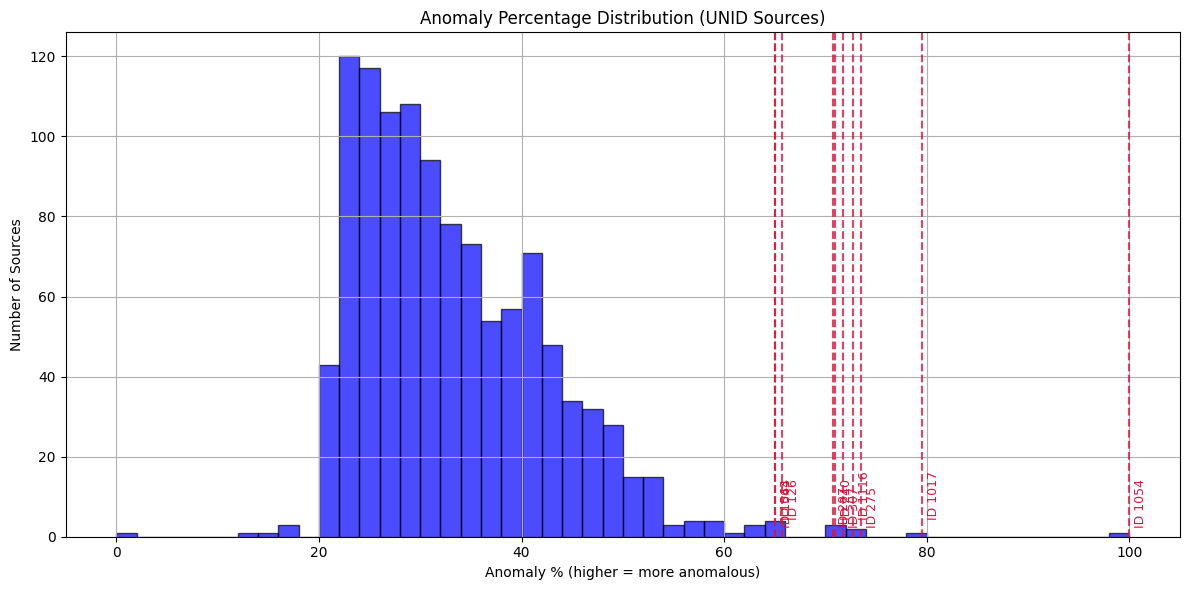

In [24]:
# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids_log.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


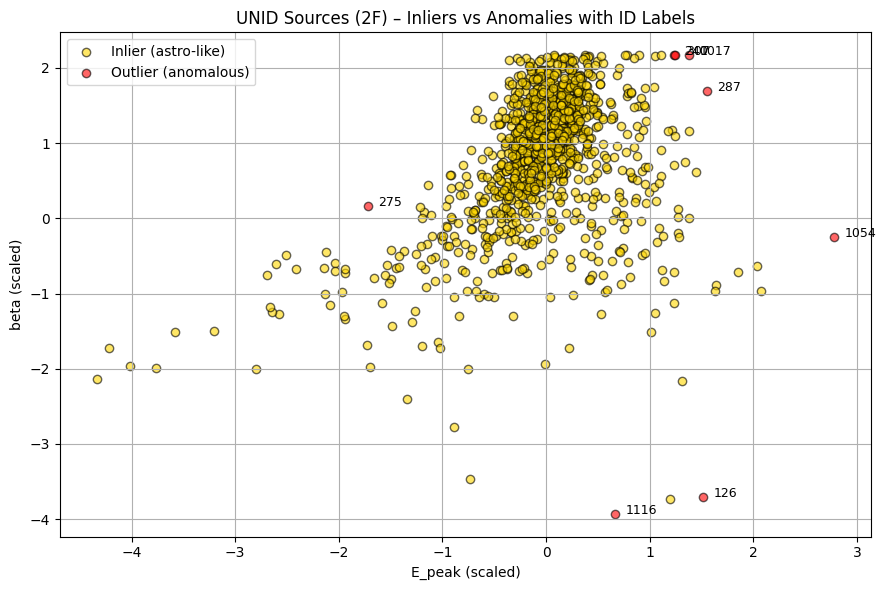

In [25]:
plt.figure(figsize=(9, 6))

# Inliers and outliers from scaled data
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

# Plot inliers (gold)
plt.scatter(inliers[:, 1], inliers[:, 0], c='gold', edgecolors='k', label='Inlier (astro-like)', alpha=0.6)

# Plot outliers (red)
plt.scatter(outliers[:, 1], outliers[:, 0], c='red', edgecolors='k', label='Outlier (anomalous)', alpha=0.6)

# Annotate top 10 anomalies by ID
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 1]  # E_peak (scaled)
    y = X_unids_scaled[idx, 0]  # beta (scaled)
    label = int(df_unids_log.loc[idx, 'number'])
    plt.text(x + 0.1, y, str(label), color='black', fontsize=9)

# Axis labels and styling
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNID Sources (2F) – Inliers vs Anomalies with ID Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../../outputs/figures/scaled/2F_UNIDs_OneClassSVM_2D_scaled.png", dpi=300, bbox_inches='tight')

plt.show()


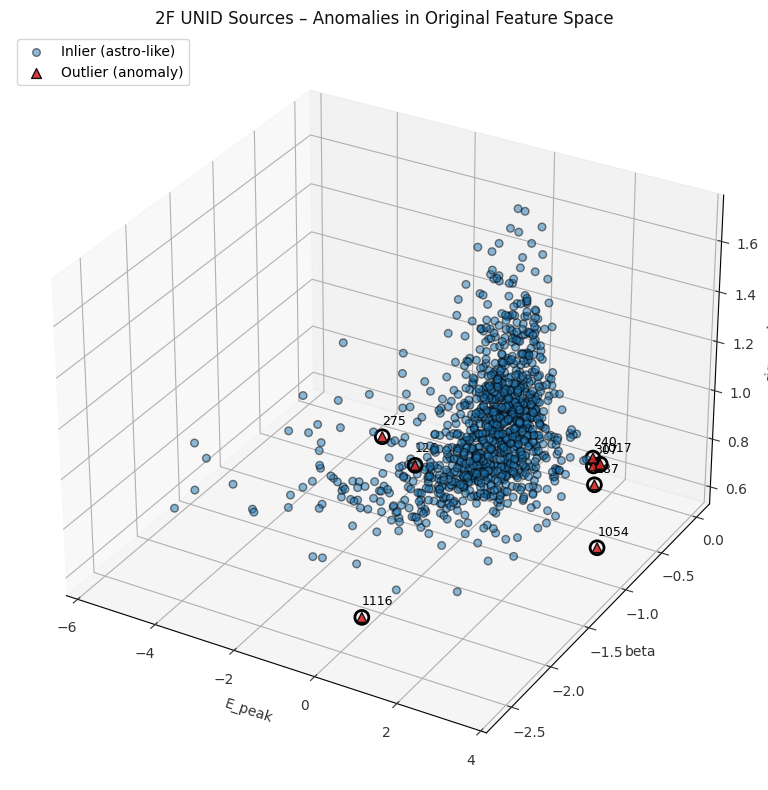

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original/log-transformed values for 3 relevant features
x_vals = df_unids_log['E_peak'].values
y_vals = df_unids_log['beta'].values
z_vals = df_unids_log['sigma_det'].values  # or 'beta_Rel' for 3F.2

# Use model predictions for coloring
inlier_idx = df_unids_log['prediction'] == 1
outlier_idx = df_unids_log['prediction'] == -1

# Inliers
ax.scatter(
    x_vals[inlier_idx], y_vals[inlier_idx], z_vals[inlier_idx],
    c='#1f77b4', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.5
)

# Outliers
ax.scatter(
    x_vals[outlier_idx], y_vals[outlier_idx], z_vals[outlier_idx],
    c='#d62728', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
top_anomalies = df_unids_log[df_unids_log['prediction'] == -1].sort_values('Anomaly_Rank(%)', ascending=False).head(10)
for idx in top_anomalies.index:
    ax.scatter(
        x_vals[idx], y_vals[idx], z_vals[idx],
        facecolors='none', edgecolors='black', linewidths=2, s=100
    )
    ax.text(
        x_vals[idx], y_vals[idx], z_vals[idx] + 0.05,
        str(int(df_unids_log.loc[idx, 'number'])),
        color='black', fontsize=9
    )

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma_det')  # or 'beta_Rel'
ax.set_title("2F UNID Sources – Anomalies in Original Feature Space")
ax.legend(loc='upper left')

ax.tick_params(colors='#333333')
ax.xaxis.label.set_color('#333333')
ax.yaxis.label.set_color('#333333')
ax.zaxis.label.set_color('#333333')
ax.title.set_color('#111111')
ax.grid(color='#aaaaaa', linestyle='--', alpha=0.3)

plt.savefig("../../outputs/figures/2F_UNIDs_OneClassSVM_og.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Comparar con UNIDs ANN

In [27]:
ann_unids_path = "../ANN_4F/unids_DM_std_proba_check_repeated_kfold_rskf_4F_21.txt"

raw_ann_unids_data = np.genfromtxt(ann_unids_path, dtype='str')
ann_unids_data = np.asarray(raw_ann_unids_data[1:], dtype=float)  # Salta cabecera
n_samples = ann_unids_data.shape[1] - 1

columns = ['number'] + [f'prob_{i}' for i in range(n_samples)]
df_unids_ann = pd.DataFrame(ann_unids_data, columns=columns)

df_unids_ann.head()

,number,prob_0
0,0.0,6.583166e-10
1,1.0,3.137251e-01
2,2.0,4.082428e-01
3,3.0,9.984947e-02
4,4.0,2.016772e-01


In [28]:
# Media por fuente y entre folds
df_mean_unids_ann = df_unids_ann.groupby('number').mean().reset_index()
df_mean_unids_ann['prob_ann'] = df_mean_unids_ann[[f'prob_{i}' for i in range(n_samples)]].mean(axis=1)

df_mean_unids_ann.head()

,number,prob_0,prob_ann
0,0.0,1.860129e-10,1.860129e-10
1,1.0,3.032059e-01,3.032059e-01
2,2.0,5.515580e-01,5.515580e-01
3,3.0,1.494101e-01,1.494101e-01
4,4.0,2.391825e-01,2.391825e-01


In [29]:
# Get the 10 sources with the highest mean ANN DM probability
top_ann_unids = df_mean_unids_ann.sort_values('prob_ann', ascending=False).head(10)

# Display results
print("🔝 Top 10 UNIDs with highest ANN-based DM probability:")
display(top_ann_unids[['number', 'prob_ann']])


🔝 Top 10 UNIDs with highest ANN-based DM probability:


,number,prob_ann
33,33.0,1.000000
843,843.0,0.999999
709,709.0,0.999995
923,923.0,0.999552
1054,1054.0,0.999522
1107,1107.0,0.999414
717,717.0,0.998058
477,477.0,0.997570
1103,1103.0,0.994799
542,542.0,0.994276


In [30]:
df_compare = pd.merge(
    df_mean_unids_ann[['number', 'prob_ann']],
    df_unids_log[['number', 'Anomaly_Rank(%)']],
    on='number'
)

# Sort by ANN prediction and OCSVM anomaly rank
df_compare.sort_values(['prob_ann', 'Anomaly_Rank(%)'], ascending=[False, False]).head(10)


,number,prob_ann,Anomaly_Rank(%)
33,33.0,1.000000,28.769370
843,843.0,0.999999,29.852710
709,709.0,0.999995,28.947387
923,923.0,0.999552,33.919744
1054,1054.0,0.999522,100.000000
1107,1107.0,0.999414,38.973824
717,717.0,0.998058,22.552814
477,477.0,0.997570,24.202793
1103,1103.0,0.994799,51.334369
542,542.0,0.994276,35.536818


In [31]:
df_compare[
    (df_compare['prob_ann'] > 0.9) & 
    (df_compare['Anomaly_Rank(%)'] > 80.0)
]


,number,prob_ann,Anomaly_Rank(%)
1054,1054.0,0.999522,100.0
